dispersion error due to sampling in estimation vs sampling in simulation

In [1]:
import numpy as onp
import pandas as pd
from itertools import product
import os
from matplotlib import pyplot as plt
import seaborn as sns
import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable
from tqdm import tqdm

import probaflow

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

2021-12-22 18:49:49.300671: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:210] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25443893248


cpu


In [3]:
os.chdir('../scripts')

In [7]:
import compute_pmass as pm
import compute_iter_metrics as cim
import large_mnl as lmnl

In [5]:
num_alts = 2000
pop_to_alts_ratio = 750 / 200
num_choosers = int(pop_to_alts_ratio * num_alts)
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
scale_params = [.25, .5, .75, 1.0, 1.25, 1.5, 1.75]
coeffs = np.array([-1, 1, 1, 1, 1])
key = random.PRNGKey(0)
num_iters = 10

# Simulate Choices and Re-estimate

In [9]:
choosers, alts = cim.create_data(num_alts, num_choosers)

### Scale Param = 1

In [73]:
deterministic = lmnl.get_probs(choosers, alts, coeffs, key, scale=1, utils=True)

random_err = onp.random.gumbel(0, 1, deterministic.shape)
utils_true = deterministic + random_err
true_choices = utils_true.argmax(axis=1)

obs_df = pd.DataFrame({'person_id': np.arange(num_choosers), 'chooser_attr': choosers, 'zone_id': true_choices})

alts_df = pd.DataFrame(alts, columns=['dist_to_cbd', 'size_1', 'size_2', 'size_3', 'intx'])
alts_df.index.name = 'zone_id'

In [74]:
%%time
mct = MergedChoiceTable(obs_df, alts_df, chosen_alternatives='zone_id')
mct_df = mct.to_frame()
mct_df['intx'] = np.sqrt((mct_df['intx'] / mct_df['chooser_attr']).values)
mct = MergedChoiceTable.from_df(mct_df)
results = MultinomialLogit(
    mct, model_expression='dist_to_cbd + size_1 + size_2 + size_3 + intx - 1')
results.fit()

CPU times: user 1min 12s, sys: 2min 59s, total: 4min 12s
Wall time: 1min 31s


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          7,500
Model:         Multinomial Logit   Df Residuals:              7,495
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2021-12-05   Pseudo R-squ.:             0.418
Time:                      23:23   Pseudo R-bar-squ.:         0.418
AIC:                  66,312.613   Log-Likelihood:      -33,151.307
BIC:                  66,347.227   LL-Null:             -57,006.768
                 coef   std err         z     P>|z|   Conf. Int.
----------------------------------------------------------------
dist_to_cbd   -0.9984     0.022   -46.182     0.000             
size_1         0.9967     0.015    67.497     0.000             
size_2         0.9880     0.013    74.599     0.000             
size_3         0.9921     0.012    85.252     0.000             
intx           1.0193     0.015    69.546     0.000             

In [75]:
%%time
mct = MergedChoiceTable(
    obs_df, alts_df, chosen_alternatives='zone_id', sample_size=int(.1 * num_alts), replace=False)
mct_df = mct.to_frame()
mct_df['intx'] = np.sqrt((mct_df['intx'] / mct_df['chooser_attr']).values)
mct = MergedChoiceTable.from_df(mct_df)
results = MultinomialLogit(
    mct, model_expression='dist_to_cbd + size_1 + size_2 + size_3 + intx - 1')
results.fit()

CPU times: user 20.8 s, sys: 43.5 s, total: 1min 4s
Wall time: 4.04 s


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          7,500
Model:         Multinomial Logit   Df Residuals:              7,495
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2021-12-05   Pseudo R-squ.:             0.542
Time:                      23:23   Pseudo R-bar-squ.:         0.542
AIC:                  36,389.359   Log-Likelihood:      -18,189.680
BIC:                  36,423.973   LL-Null:             -39,737.380
                 coef   std err         z     P>|z|   Conf. Int.
----------------------------------------------------------------
dist_to_cbd   -0.9975     0.024   -41.410     0.000             
size_1         0.9956     0.016    63.938     0.000             
size_2         0.9866     0.014    69.825     0.000             
size_3         0.9934     0.013    78.318     0.000             
intx           1.0088     0.016    62.339     0.000             

### Scale Param = 2

In [10]:
deterministic = lmnl.get_probs(choosers, alts, coeffs, key, scale=2, utils=True)

random_err = onp.random.gumbel(0, 2, deterministic.shape)
utils_true = deterministic + random_err
true_choices = utils_true.argmax(axis=1)

obs_df = pd.DataFrame({'person_id': np.arange(num_choosers), 'chooser_attr': choosers, 'zone_id': true_choices})

alts_df = pd.DataFrame(alts, columns=['dist_to_cbd', 'size_1', 'size_2', 'size_3', 'intx'])
alts_df.index.name = 'zone_id'

Took 0.0 s to compute true probabilities.


In [11]:
%%time
mct = MergedChoiceTable(obs_df, alts_df, chosen_alternatives='zone_id')
mct_df = mct.to_frame()
mct_df['intx'] = np.sqrt((mct_df['intx'] / mct_df['chooser_attr']).values)
mct = MergedChoiceTable.from_df(mct_df)
results = MultinomialLogit(
    mct, model_expression='dist_to_cbd + size_1 + size_2 + size_3 + intx - 1')
results.fit()

CPU times: user 1min 8s, sys: 1min 42s, total: 2min 51s
Wall time: 19.7 s


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          7,500
Model:         Multinomial Logit   Df Residuals:              7,495
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2021-12-22   Pseudo R-squ.:             0.248
Time:                      18:50   Pseudo R-bar-squ.:         0.247
AIC:                  85,796.110   Log-Likelihood:      -42,893.055
BIC:                  85,830.724   LL-Null:             -57,006.768
                 coef   std err         z     P>|z|   Conf. Int.
----------------------------------------------------------------
dist_to_cbd   -0.9816     0.020   -50.137     0.000             
size_1         1.0065     0.012    82.182     0.000             
size_2         1.0037     0.010   101.219     0.000             
size_3         1.0177     0.010    97.164     0.000             
intx           0.9941     0.011    86.686     0.000             

In [78]:
%%time
mct = MergedChoiceTable(
    obs_df, alts_df, chosen_alternatives='zone_id', sample_size=int(.1 * num_alts), replace=False)
mct_df = mct.to_frame()
mct_df['intx'] = np.sqrt((mct_df['intx'] / mct_df['chooser_attr']).values)
mct = MergedChoiceTable.from_df(mct_df)
results = MultinomialLogit(
    mct, model_expression='dist_to_cbd + size_1 + size_2 + size_3 + intx - 1')
results.fit()

CPU times: user 27 s, sys: 1min, total: 1min 27s
Wall time: 4.66 s


                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          7,500
Model:         Multinomial Logit   Df Residuals:              7,495
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2021-12-05   Pseudo R-squ.:             0.981
Time:                      23:25   Pseudo R-bar-squ.:         0.981
AIC:                   1,506.592   Log-Likelihood:         -748.296
BIC:                   1,541.205   LL-Null:             -39,737.380
                 coef   std err         z     P>|z|   Conf. Int.
----------------------------------------------------------------
dist_to_cbd   -1.9674     0.169   -11.638     0.000             
size_1         1.9932     0.094    21.174     0.000             
size_2         2.0117     0.071    28.467     0.000             
size_3         2.0059     0.054    37.152     0.000             
intx           2.0372     0.086    23.777     0.000             

# Simulate Dispersion Err w Diff Scale Params

In [5]:
df = pd.DataFrame()

In [6]:
pop_to_alts_ratio = 750 / 200
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
scale_params = [.25, .5, .75, 1.0, 1.25, 1.5, 1.75]
coeffs = np.array([-1, 1, 1, 1, 1])
key = random.PRNGKey(0)
alts_to_iters = {200: 100, 2000: 50, 20000: 10}

In [7]:
for num_alts in [2000]:
    if len(df) > 0:
        run_id = df['run_id'].max()
    else:
        run_id = 1
    num_iters = alts_to_iters[num_alts]
    for i in tqdm(range(num_iters)):
        run_id += 1
        iter_df = pd.DataFrame()
        for scale_param in scale_params:
            scale_df = pm.run_v2(
                num_alts, pop_to_alts_ratio, sample_rates, coeffs, key, batched=True,
                scale=scale_param, debug=True, verbose=False)
            scale_df['scale'] = scale_param
            iter_df = pd.concat((iter_df, scale_df), ignore_index=True)
        iter_df['run_id'] = run_id
        iter_df['num_alts'] = num_alts
        iter_df['num_choosers'] = int(pop_to_alts_ratio * num_alts)
        iter_df['pct_abs_err'] = iter_df['total_abs_err'] / iter_df['num_choosers']
        df = pd.concat((df, iter_df), ignore_index=True)

og_df = df

  0%|                                                                                                                          | 0/100 [00:01<?, ?it/s]


AssertionError: 

In [8]:
%debug

> /home/mgardner/simulation_bias/scripts/compute_pmass.py(105)run_v2()
    103 
    104     if debug:
--> 105         assert np.isclose(
    106             all_prob_mass.sum(axis=1), num_choosers, rtol=3e-4).all()
    107 

ipdb> all_prob_mass.sum(axis=1)
DeviceArray([741.30066, 738.8699 , 738.80066, 738.77313, 738.4298 ,
             737.7117 , 737.9765 , 737.8197 , 737.71326, 737.62555],            dtype=float32)
ipdb> all_prob_mass.shape
(10, 200)
ipdb> exit


In [90]:
df.to_csv("../data/disp_err_scale_iters.csv", index=False)

In [75]:
df = og_df

In [81]:
num_metrics = 5
non_metric_cols = ['num_alts', 'num_choosers', 'sample_rate','run_id']
metric_cols = ['total_abs_err', 'pct_abs_err', 'rmse', 'mape', 'sd_pct_err']
metric_labels = [
    "Total Absolute Error",
    "Pct Abs Err",
    "RMSE",
    "MAPE",
    "Std. Dev. Pct. Err.",
]

for col in metric_cols:
    df[col] = df[col].astype(float).abs()

In [26]:
# standardize errs by sample rate
maxs = df[df['scale'] == max(scale_params)].abs().groupby(['run_id', 'sample_rate'])[['total_abs_err', 'pct_abs_err', 'rmse', 'mape', 'sd_pct_err']].mean()
maxs = maxs.reset_index().rename(columns={col: col + '_max_rate' for col in maxs.columns})
df = pd.merge(df, maxs, on=['run_id', 'sample_rate'])
for col in metric_cols:
    df[col + '_std_rate'] = df[col] / df[col + '_max_rate']
    df.loc[df[col + '_max_rate'] == 0, col + '_std_rate'] = 0
    
# standardize errs by scale
maxs = df[df['sample_rate'] == min(sample_rates)].abs().groupby(['run_id', 'scale'])[['total_abs_err', 'pct_abs_err', 'rmse', 'mape', 'sd_pct_err']].mean()
maxs = maxs.reset_index().rename(columns={col: col + '_max_scale' for col in maxs.columns})
df = pd.merge(df, maxs, on=['run_id', 'scale'])
for col in metric_cols:
    df[col + '_std_scale'] = df[col] / df[col + '_max_scale']
    df.loc[df[col + '_max_scale'] == 0, col + '_std_scale'] = 0

n=20000

Text(0, 0.5, 'Raw')

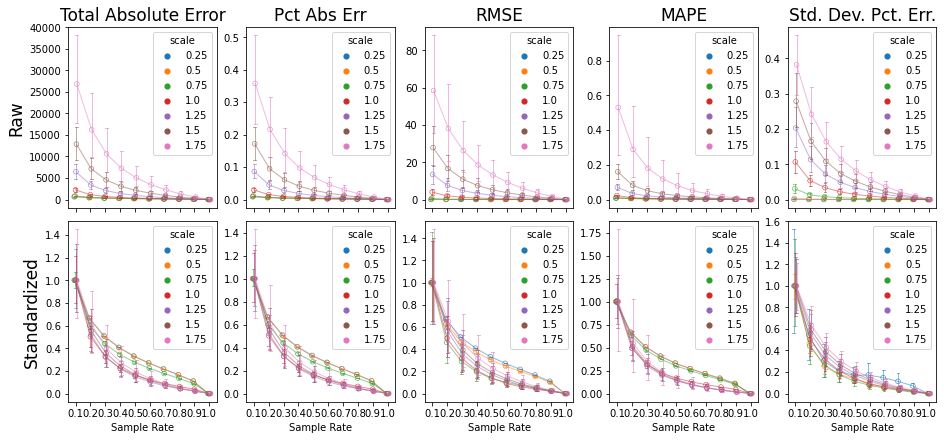

In [19]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(13, 6), sharex=True, constrained_layout=True)

for col, metric in enumerate(metric_cols):
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric,
        hue='scale', dodge=True, scale=0.7, ax=axarr[0, col], capsize=.2)

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

    axarr[0, col].set_title(metric_labels[col], fontsize=17)
    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric + '_std_scale',
        hue='scale', dodge=True, scale=0.7, ax=axarr[1, col], capsize=.2)
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Sample Rate")

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

axarr[1, 0].set_ylabel("Standardized", fontsize=17)
axarr[0, 0].set_ylabel("Raw", fontsize=17)

n=2000

Text(0, 0.5, 'Raw')

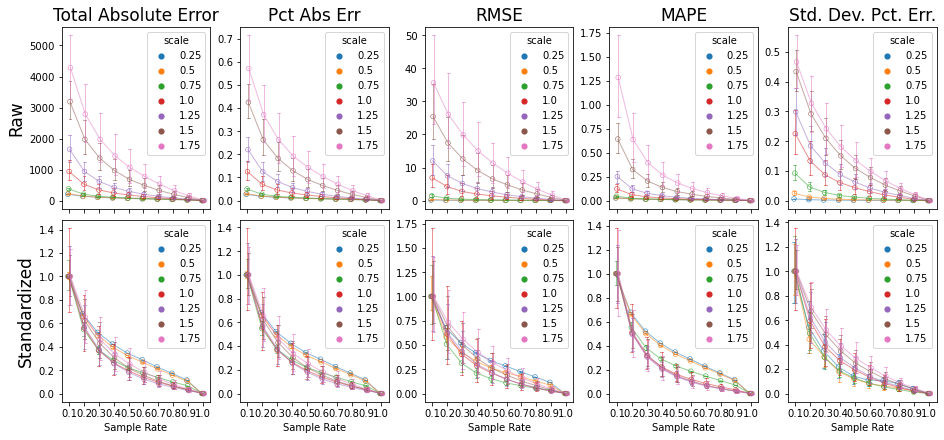

In [27]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(13, 6), sharex=True, constrained_layout=True)

for col, metric in enumerate(metric_cols):
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric,
        hue='scale', dodge=True, scale=0.7, ax=axarr[0, col], capsize=.2)

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

    axarr[0, col].set_title(metric_labels[col], fontsize=17)
    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric + '_std_scale',
        hue='scale', dodge=True, scale=0.7, ax=axarr[1, col], capsize=.2)
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Sample Rate")

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

axarr[1, 0].set_ylabel("Standardized", fontsize=17)
axarr[0, 0].set_ylabel("Raw", fontsize=17)

In [7]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(14, 5), sharex=True, sharey=True, constrained_layout=True)

for col, metric in enumerate(metric_cols):
    
    g = sns.heatmap(
        df[['sample_rate','scale', metric]].pivot_table(
            index='scale',columns='sample_rate',values=metric), ax=axarr[0, col], square=True,
            cbar_kws={"shrink": .72}, cmap='RdYlGn_r')

    axarr[0, col].set_title(metric_labels[col], fontsize=17)
    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.heatmap(
        df[['sample_rate','scale', metric + '_std_scale']].pivot_table(
            index='scale',columns='sample_rate',values=metric + '_std_scale'), ax=axarr[1, col],
            vmin=0, vmax=1, square=True, cbar_kws={"shrink": .72}, cmap='RdYlGn_r')
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Sample Rate")

_ = axarr[1, 0].set_ylabel("Scale")
_ = axarr[0, 0].set_ylabel("Scale")
_ = axarr[0, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')
_ = axarr[1, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')

NameError: name 'num_metrics' is not defined

Text(0, 0.5, 'Raw')

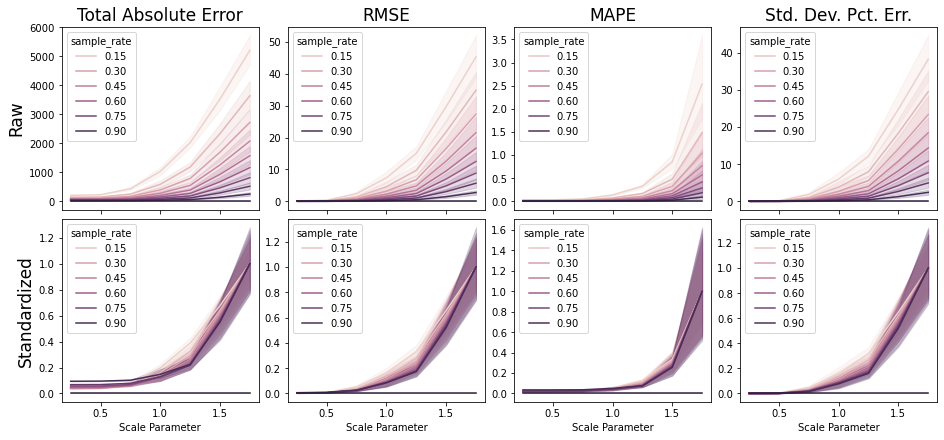

In [121]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(13, 6), sharex=True, constrained_layout=True)

for col, metric in enumerate(metric_cols):
    
    df[metric] = df[metric].astype(float)
    
    g = sns.lineplot(
        data=df,
        x='scale', y=metric,
        hue='sample_rate', ax=axarr[0, col])

    axarr[0, col].set_title(metric_labels[col], fontsize=17)

    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.lineplot(
        data=df,
        x='scale', y=metric + '_std_rate',
        hue='sample_rate', ax=axarr[1, col])
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Scale Parameter")
    
axarr[1, 0].set_ylabel("Standardized", fontsize=17)
axarr[0, 0].set_ylabel("Raw", fontsize=17)

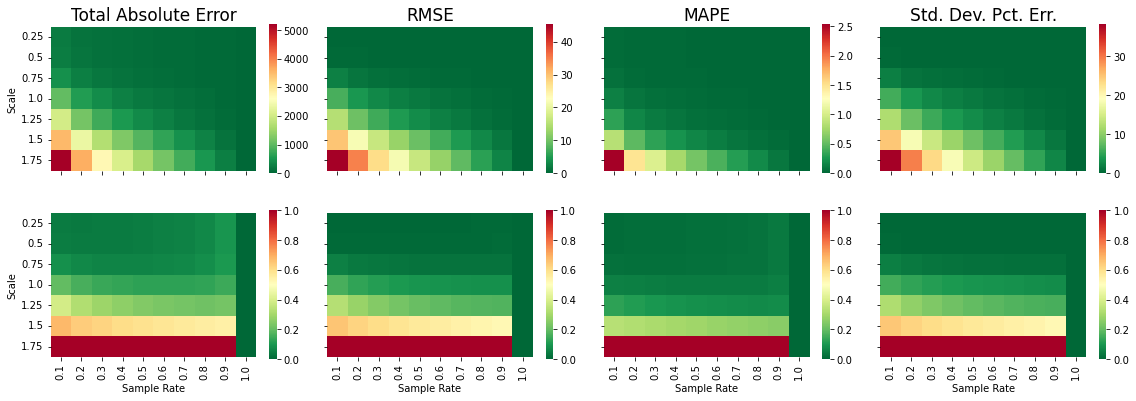

In [138]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(16, 6), sharex=True, sharey=True,)

for col, metric in enumerate(metric_cols):
    
    g = sns.heatmap(
        df[['sample_rate','scale', metric]].pivot_table(
            index='scale',columns='sample_rate',values=metric), ax=axarr[0, col], square=True,
        cbar_kws={"shrink": .72}, cmap='RdYlGn_r')

    axarr[0, col].set_title(metric_labels[col], fontsize=17)
    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.heatmap(
        df[['sample_rate','scale', metric + '_std_rate']].pivot_table(
            index='scale',columns='sample_rate',values=metric + '_std_rate'), ax=axarr[1, col],
        vmin=0, vmax=1, square=True, cbar_kws={"shrink": .72}, cmap='RdYlGn_r')
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Sample Rate")

_ = axarr[1, 0].set_ylabel("Scale")
_ = axarr[0, 0].set_ylabel("Scale")
_ = axarr[0, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')
_ = axarr[1, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')
fig.tight_layout()

# scale vs num alts

In [281]:
df = df.replace(np.inf, np.nan)

In [312]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

Text(0.5, 0.98, '% Dispersion Error')

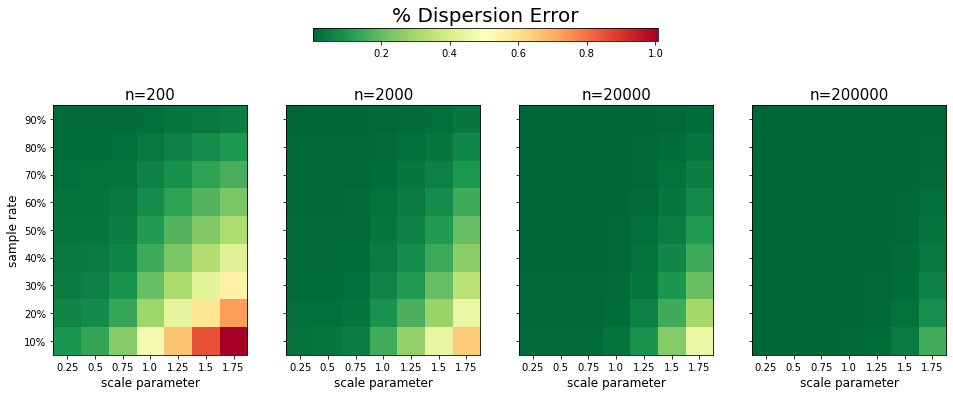

In [374]:

num_alts_values = [200, 2000, 20000, 200000]
num_num_alts_values = len(num_alts_values)
fig, axarr = plt.subplots(1, num_num_alts_values, figsize=(16,6), sharey=True)
vmax = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['pct_abs_err'].mean().max()
vmin = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['pct_abs_err'].mean().min()
for i, ax in enumerate(axarr):
    
    tmp_df = df[(df['num_alts'] == num_alts_values[i]) & (df['sample_rate'] < 1)]
    tmp_df['sample_rate'] = (tmp_df['sample_rate'] * 100).astype('int').astype(str) + '%'
    piv_df = tmp_df.pivot_table(index='sample_rate', columns='scale', values='pct_abs_err')
    piv_df = piv_df.sort_index(level=0, ascending=False)
    im = ax.imshow(piv_df, cmap='RdYlGn_r', vmin=vmin, vmax=vmax)
    ax.set_ylabel("")
    ax.set_xlabel("scale parameter", fontsize=12)
    xticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(list(np.arange(len(scale_params))))
    ax.set_xticklabels(list(scale_params))
    ax.set_title("n={0}".format(num_alts_values[i]), fontsize=15)

_ = axarr[0].set_ylabel("sample rate", fontsize=12)
_ = axarr[0].set_yticks(list(np.arange(len(list(piv_df.index.values)))))
_ = axarr[0].set_yticklabels(list(piv_df.index.values), rotation='horizontal')
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.35, 0.9, 0.3, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
fig.suptitle("% Dispersion Error", fontsize=20)


Text(0.5, 0.98, 'RMSE')

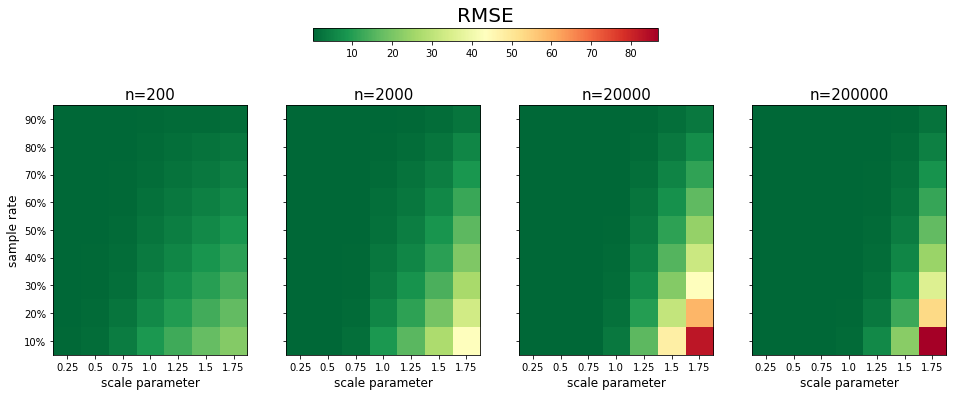

In [376]:
num_alts_values = [200, 2000, 20000, 200000]
num_num_alts_values = len(num_alts_values)
fig, axarr = plt.subplots(1, num_num_alts_values, figsize=(16,6), sharey=True)
vmax = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['rmse'].mean().max()
vmin = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['rmse'].mean().min()
for i, ax in enumerate(axarr):
    
    tmp_df = df[(df['num_alts'] == num_alts_values[i]) & (df['sample_rate'] < 1)]
    tmp_df['sample_rate'] = (tmp_df['sample_rate'] * 100).astype('int').astype(str) + '%'
    piv_df = tmp_df.pivot_table(index='sample_rate', columns='scale', values='rmse')
    piv_df = piv_df.sort_index(level=0, ascending=False)
    im = ax.imshow(
        piv_df, cmap='RdYlGn_r', 
#         norm=LogNorm(vmin=vmin, vmax=vmax)
        vmin=vmin, vmax=vmax
    )
    ax.set_ylabel("")
    ax.set_xlabel("scale parameter", fontsize=12)
    xticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(list(np.arange(len(scale_params))))
    ax.set_xticklabels(list(scale_params))
    ax.set_title("n={0}".format(num_alts_values[i]), fontsize=15)

_ = axarr[0].set_ylabel("sample rate", fontsize=12)
_ = axarr[0].set_yticks(list(np.arange(len(list(piv_df.index.values)))))
_ = axarr[0].set_yticklabels(list(piv_df.index.values), rotation='horizontal')
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.35, 0.9, 0.3, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
fig.suptitle("RMSE", fontsize=20)

Text(0.5, 0.98, 'MAPE')

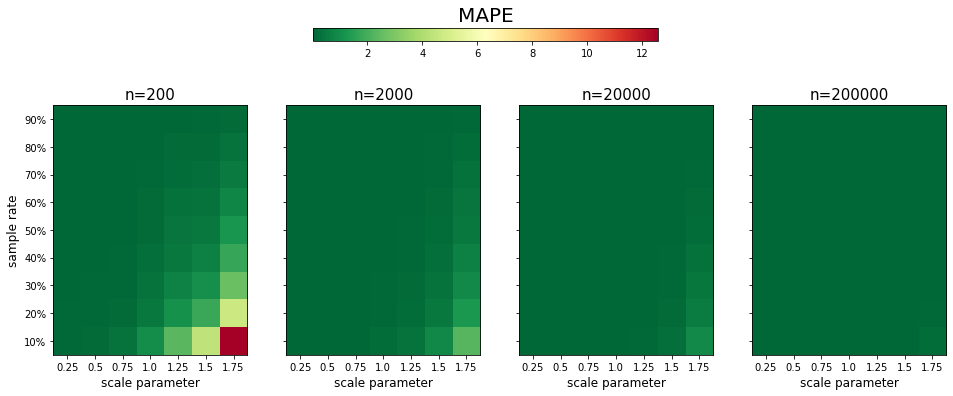

In [375]:
num_alts_values = [200, 2000, 20000, 200000]
num_num_alts_values = len(num_alts_values)
fig, axarr = plt.subplots(1, num_num_alts_values, figsize=(16,6), sharey=True)
vmax = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['mape'].mean().max()
vmin = df[df['sample_rate'] < 1].groupby(['sample_rate', 'scale', 'num_alts'])['mape'].mean().min()
for i, ax in enumerate(axarr):
    
    tmp_df = df[(df['num_alts'] == num_alts_values[i]) & (df['sample_rate'] < 1)]
    tmp_df['sample_rate'] = (tmp_df['sample_rate'] * 100).astype('int').astype(str) + '%'
    piv_df = tmp_df.pivot_table(index='sample_rate', columns='scale', values='mape')
    piv_df = piv_df.sort_index(level=0, ascending=False)
    im = ax.imshow(
        piv_df, cmap='RdYlGn_r', 
#         norm=LogNorm(vmin=vmin, vmax=vmax)
        vmin=vmin, vmax=vmax
        
    )
    ax.set_ylabel("")
    ax.set_xlabel("scale parameter", fontsize=12)
    xticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(list(np.arange(len(scale_params))))
    ax.set_xticklabels(list(scale_params))
    ax.set_title("n={0}".format(num_alts_values[i]), fontsize=15)

_ = axarr[0].set_ylabel("sample rate", fontsize=12)
_ = axarr[0].set_yticks(list(np.arange(len(list(piv_df.index.values)))))
_ = axarr[0].set_yticklabels(list(piv_df.index.values), rotation='horizontal')
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.35, 0.9, 0.3, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
fig.suptitle("MAPE", fontsize=20)